## Введение
В данном эксперименте рассматриваются задачи достижимости:
1. между всеми парами вершин
2. вершин с заданным множеством стартовых вершин
3. вершин для каждой из заданного множества стартовых вершин

Было реализовано два алгоритма для выполнения регулярных запросов к графам. Идея первого алгоритма заключается в пересечении автомата, созданного на основе графа, и автомата, созданного на основе регулярного выражения, с последующим нахождением транзитивного замыкания. Идея второго алгоритма заключается в синхронном обходе автоматов в ширину.

## Цель
Необходимо сравнить работу алгоритмов при различных начальных условиях.

## Наборы данных
Выбор графов обусловлен тем, что хотелось выбрать графы различных размеров, а так же на графах больших по числу узлов и ребер чем [core](https://jetbrains-research.github.io/CFPQ_Data/dataset/data/core.html#core) работа алгоритмов занимала слишком много времени. Работа алгоритмов проверяется на следующих графах:

1. [atom](https://jetbrains-research.github.io/CFPQ_Data/dataset/data/atom.html#atom)
2. [pizza](https://jetbrains-research.github.io/CFPQ_Data/dataset/data/pizza.html#pizza)
3. [core](https://jetbrains-research.github.io/CFPQ_Data/dataset/data/core.html#core)

Для генерации регулярных выражений используются 4 самые распространенные метки на ребрах графа и строятся по следующему шаблону, где l1, l2, l3, l4
метки ребер:

   1.       (l1 | l2)* l3
   2.       (l3 | l4)+ l1*
   3.       l1 l2 l3 (l4|l1)*

Работа алгоритмов проверяется на следующих разреженных матрицах:

1. [lil_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html)
2. [dok_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.dok_matrix.html)
3. [csr_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html)
4. [csc_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html)

## Описание эксперимента

#### Технические характеристики машины:
Процессор: core i7-10750H 2.60GHz, 6 ядер, 12 логических процессоров.
Кэш: 1ого уровня - 384 Кб, 2ого уровня 1,5 Мб, 3его уровня 12 Мб.
Объем оперативной памяти: 16гб, 2933 МГц.
ОС: Windows 10.
Версия Python: 3.9.6

#### Проведение замеров:
Замеры времени производятся в секундах при помощи библиотеки [time](https://docs.python.org/3/library/time.html). Замеряется время работы функций из файла rpq вместе с созданием объектов BoolAutomaton, так как при их инициализации происходит запись данных в соответствующие разреженные матрицы. На каждый вариант набора данных производится 10 запусков, вычисляется среднее арифметическое и стандартное отклонение значений времени и выводятся все замеры в виде диаграмм.



**Импортируем необходимые библиотеки и инициализируем глобальные переменные для эксперимента**

In [15]:
import time
from collections import Counter

import cfpq_data
from prettytable import PrettyTable
from pyformlang.regular_expression import Regex
from scipy import stats
from scipy.sparse import csr_matrix, dok_matrix, csc_matrix
import matplotlib.pyplot as plt
import numpy as np

from project.rpq import *

NUMBER_OF_LAUNCHES = 3
PERCENT_OF_SOURCES = 20.0
SEED = 42
TYPE_MATRICES = [lil_matrix, dok_matrix, csr_matrix, csc_matrix]
dataset_graph = ["pizza"]

**Функция для pretty printing**

In [2]:
def print_table(header, rows):
    tab = PrettyTable(header)
    tab.field_names = header
    tab.add_rows(rows)
    print(tab)

**Функция для отрисовки диаграммы**

In [3]:
def draw_diagram(graph_name, percent_of_sources, matrix_time, matrix_deviation, type_matrices):
    index = np.arange(0, 3, 1)
    bw = 0.2
    plt.title(graph_name + " " + percent_of_sources + "% of sources", fontsize=15)
    colors = ["y", "r", "b", "g"]
    for count, name_matrix in enumerate(type_matrices):
        plt.bar(index + bw * (count + 1), matrix_time[name_matrix.__name__], bw,
                yerr=matrix_deviation[name_matrix.__name__],
                error_kw={'ecolor': '0.1', 'capsize': 6}, alpha=0.7, color=colors[count], label=name_matrix.__name__)

    plt.xticks(index + 1 * bw, ["(l1 | l2)* l3", "(l3 | l4)+ l1*", "l1 l2 l3 (l4|l1)*"])
    plt.legend(loc=1)
    plt.show()

**Функция для генерации регулярных выражений по графу**

In [4]:
def generate_regexes(graph):
    most_common_labels = Counter(list(map(lambda node: node[2]["label"], graph.edges.data()))).most_common(4)
    return [
        "(" + str(most_common_labels[0][0]) + "|" + str(most_common_labels[1][0]) + ")*" + str(
            most_common_labels[2][0]),
        "(" + str(most_common_labels[2][0]) + "|" + str(most_common_labels[3][0]) + ")|(" + str(
            most_common_labels[2][0]) + "|" + str(most_common_labels[3][0]) + ")*" + str(
            most_common_labels[0][0]) + "*",
        str(most_common_labels[0][0]) + " " + str(most_common_labels[1][0]) + " " + str(
            most_common_labels[2][0]) + "(" + str(most_common_labels[3][0]) + "|" + str(
            most_common_labels[0][0]) + ")*",
    ]

#### Достижимость между всеми парами вершин

In [5]:
def rpq_all_pairs(type_matrices=TYPE_MATRICES, type_rpq=rpq_by_bfs):
    for graph_name in dataset_graph:
        graph = cfpq_data.graph_from_csv(cfpq_data.download(graph_name))
        regexes = generate_regexes(graph)
        matrix_time = {"lil_matrix": [], "dok_matrix": [], "csr_matrix": [], "csc_matrix": []}
        matrix_deviation = {"lil_matrix": [], "dok_matrix": [], "csr_matrix": [], "csc_matrix": []}
        for regex in regexes:
            request = Regex(regex)
            for type_matrix in type_matrices:
                times = []
                for i in range(NUMBER_OF_LAUNCHES):
                    start_time = time.time()
                    type_rpq(graph=graph, regex=request, start_states=None, final_states=None,
                             for_each_start=True,
                             type_of_matrix=type_matrix)
                    final_time = time.time() - start_time
                    times.append(final_time)
                mean_time = np.mean(times)
                deviation = stats.tstd(times)
                matrix_time[type_matrix.__name__].append(mean_time)
                matrix_deviation[type_matrix.__name__].append(deviation)
        draw_diagram(graph_name, "100", matrix_time, matrix_deviation, type_matrices)


#### Достижимость вершин с заданным множеством стартовых вершин

In [6]:
def rpq_specified_vertexes(perc_of_src=PERCENT_OF_SOURCES, type_matrices=TYPE_MATRICES, type_rpq=rpq_by_bfs):
    for graph_name in dataset_graph:
        graph = cfpq_data.graph_from_csv(cfpq_data.download(graph_name))
        source_vertices = cfpq_data.generate_multiple_source_percent(graph, perc_of_src, seed=SEED)
        regexes = generate_regexes(graph)
        matrix_time = {"lil_matrix": [], "dok_matrix": [], "csr_matrix": [], "csc_matrix": []}
        matrix_deviation = {"lil_matrix": [], "dok_matrix": [], "csr_matrix": [], "csc_matrix": []}
        for regex in regexes:
            request = Regex(regex)
            for type_matrix in type_matrices:
                times = []
                for i in range(NUMBER_OF_LAUNCHES):
                    start_time = time.time()
                    type_rpq(graph=graph, regex=request, start_states=source_vertices, final_states=None,
                             for_each_start=False,
                             type_of_matrix=type_matrix)
                    final_time = time.time() - start_time
                    times.append(final_time)
                mean_time = np.mean(times)
                deviation = stats.tstd(times)
                matrix_time[type_matrix.__name__].append(mean_time)
                matrix_deviation[type_matrix.__name__].append(deviation)
        draw_diagram(graph_name, str(int(perc_of_src)), matrix_time, matrix_deviation, type_matrices)


#### Достижимость вершин для каждой из заданного множества стартовых вершин (BFS)

In [7]:
def rpq_specified_vertexes_for_each_start(perc_of_src=PERCENT_OF_SOURCES, type_matrices=TYPE_MATRICES,
                                                 type_rpq=rpq_by_bfs):
    for graph_name in dataset_graph:
        graph = cfpq_data.graph_from_csv(cfpq_data.download(graph_name))
        source_vertices = cfpq_data.generate_multiple_source_percent(graph, perc_of_src, seed=SEED)
        regexes = generate_regexes(graph)
        matrix_time = {"lil_matrix": [], "dok_matrix": [], "csr_matrix": [], "csc_matrix": []}
        matrix_deviation = {"lil_matrix": [], "dok_matrix": [], "csr_matrix": [], "csc_matrix": []}
        for regex in regexes:
            request = Regex(regex)
            for type_matrix in type_matrices:
                times = []
                for i in range(NUMBER_OF_LAUNCHES):
                    start_time = time.time()
                    type_rpq(graph=graph, regex=request, start_states=source_vertices, final_states=None,
                               for_each_start=True,
                               type_of_matrix=type_matrix)
                    final_time = time.time() - start_time
                    times.append(final_time)
                mean_time = np.mean(times)
                deviation = stats.tstd(times)
                matrix_time[type_matrix.__name__].append(mean_time)
                matrix_deviation[type_matrix.__name__].append(deviation)
        draw_diagram(graph_name, str(int(perc_of_src)), matrix_time, matrix_deviation, type_matrices)


## Сравним работу алгоритмов основанных на синхронном обходе в ширину и на тензорном произведении.

**Достижимость между всеми парами вершин**


Тензорное произведение:

[2022-10-19 23:37:13]>INFO>Found graph with name='pizza'
[2022-10-19 23:37:13]>INFO>Load archive graph_archive=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza.tar.gz')
[2022-10-19 23:37:13]>INFO>Unzip graph name='pizza' to file graph=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza/pizza.csv')
[2022-10-19 23:37:13]>INFO>Remove archive graph_archive=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza.tar.gz')
[2022-10-19 23:37:13]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x0000020EFC893C10> from path=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza/pizza.csv')
D:\GitHub\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
D:\GitHub\formal-lang

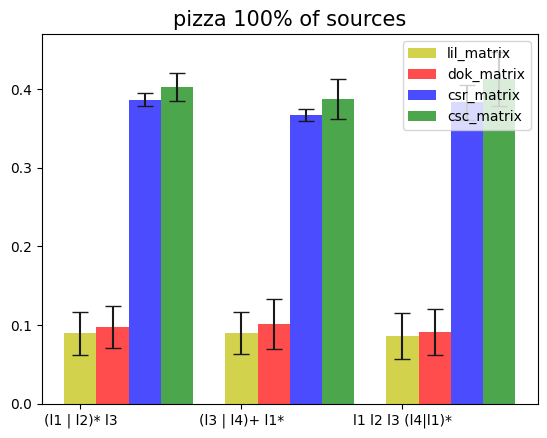

In [8]:
rpq_all_pairs(type_rpq=rpq_by_tensor)

Синхронный обход в ширину:

[2022-10-19 23:37:19]>INFO>Found graph with name='pizza'
[2022-10-19 23:37:19]>INFO>Load archive graph_archive=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza.tar.gz')
[2022-10-19 23:37:19]>INFO>Unzip graph name='pizza' to file graph=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza/pizza.csv')
[2022-10-19 23:37:19]>INFO>Remove archive graph_archive=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza.tar.gz')
[2022-10-19 23:37:19]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x0000020EFC8FA730> from path=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza/pizza.csv')
D:\GitHub\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
D:\GitHub\formal-lang-

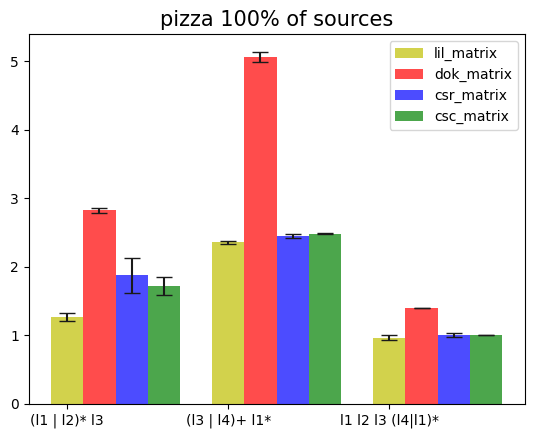

In [9]:
rpq_all_pairs(type_rpq=rpq_by_bfs)

Исходя из полученных данных можно сделать вывод, что решать задачу `достижимости между всеми парами вершин` выгоднее алгоритмом, основанным на тензорном произведении.

**Достижимость вершин для каждой из заданного множества стартовых вершин**

Тензорное произведение:

[2022-10-19 23:46:20]>INFO>Found graph with name='pizza'
[2022-10-19 23:46:20]>INFO>Load archive graph_archive=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza.tar.gz')
[2022-10-19 23:46:20]>INFO>Unzip graph name='pizza' to file graph=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza/pizza.csv')
[2022-10-19 23:46:20]>INFO>Remove archive graph_archive=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza.tar.gz')
[2022-10-19 23:46:20]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x0000020EFF8CE250> from path=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza/pizza.csv')
[2022-10-19 23:46:20]>INFO>Generate set of source vertices of 67 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x0000020EFF8CE250> for multiple-source evaluation
D:\GitHub\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.p

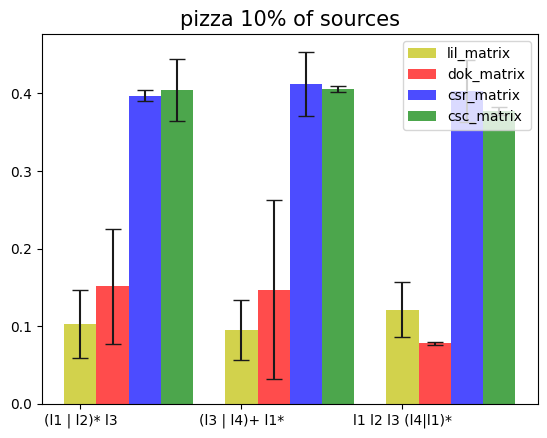

[2022-10-19 23:46:30]>INFO>Found graph with name='pizza'
[2022-10-19 23:46:30]>INFO>Load archive graph_archive=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza.tar.gz')
[2022-10-19 23:46:30]>INFO>Unzip graph name='pizza' to file graph=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza/pizza.csv')
[2022-10-19 23:46:30]>INFO>Remove archive graph_archive=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza.tar.gz')
[2022-10-19 23:46:30]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x0000020ECB6EBBB0> from path=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza/pizza.csv')
[2022-10-19 23:46:30]>INFO>Generate set of source vertices of 201 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x0000020ECB6EBBB0> for multiple-source evaluation


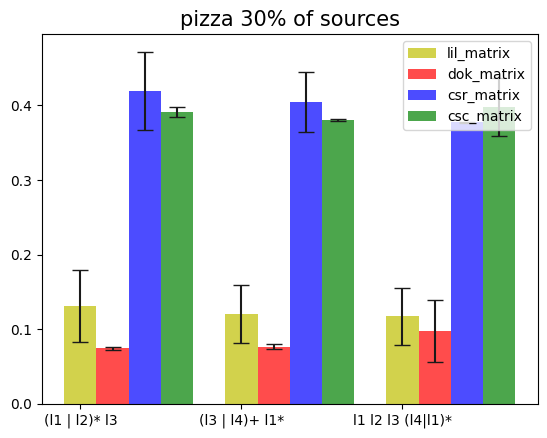

[2022-10-19 23:46:39]>INFO>Found graph with name='pizza'
[2022-10-19 23:46:39]>INFO>Load archive graph_archive=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza.tar.gz')
[2022-10-19 23:46:39]>INFO>Unzip graph name='pizza' to file graph=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza/pizza.csv')
[2022-10-19 23:46:39]>INFO>Remove archive graph_archive=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza.tar.gz')
[2022-10-19 23:46:39]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x0000020EFCAC0460> from path=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza/pizza.csv')
[2022-10-19 23:46:39]>INFO>Generate set of source vertices of 335 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x0000020EFCAC0460> for multiple-source evaluation


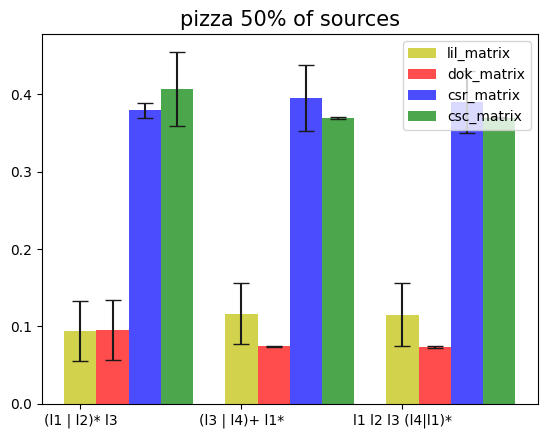

In [16]:
perc_of_src = [10.0, 30.0, 50.0]
for perc in perc_of_src:
    rpq_specified_vertexes_for_each_start(perc_of_src=perc,type_rpq=rpq_by_tensor)

Синхронный обход в ширину:

[2022-10-19 23:46:48]>INFO>Found graph with name='pizza'
[2022-10-19 23:46:48]>INFO>Load archive graph_archive=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza.tar.gz')
[2022-10-19 23:46:48]>INFO>Unzip graph name='pizza' to file graph=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza/pizza.csv')
[2022-10-19 23:46:48]>INFO>Remove archive graph_archive=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza.tar.gz')
[2022-10-19 23:46:48]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x0000020EFF741880> from path=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza/pizza.csv')
[2022-10-19 23:46:48]>INFO>Generate set of source vertices of 67 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x0000020EFF741880> for multiple-source evaluation
D:\GitHub\formal-lang-course\venv\lib\site-packages\scipy\sparse\_index.p

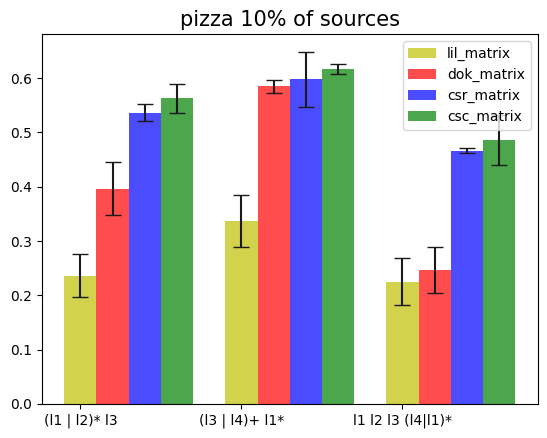

[2022-10-19 23:47:04]>INFO>Found graph with name='pizza'
[2022-10-19 23:47:04]>INFO>Load archive graph_archive=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza.tar.gz')
[2022-10-19 23:47:04]>INFO>Unzip graph name='pizza' to file graph=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza/pizza.csv')
[2022-10-19 23:47:04]>INFO>Remove archive graph_archive=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza.tar.gz')
[2022-10-19 23:47:04]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x0000020ECB6BDEE0> from path=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza/pizza.csv')
[2022-10-19 23:47:04]>INFO>Generate set of source vertices of 201 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x0000020ECB6BDEE0> for multiple-source evaluation


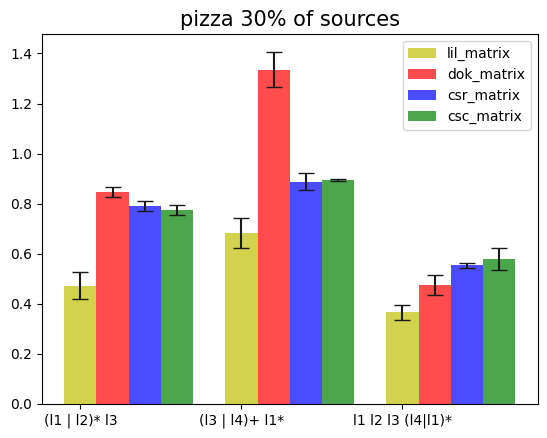

[2022-10-19 23:47:30]>INFO>Found graph with name='pizza'
[2022-10-19 23:47:30]>INFO>Load archive graph_archive=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza.tar.gz')
[2022-10-19 23:47:30]>INFO>Unzip graph name='pizza' to file graph=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza/pizza.csv')
[2022-10-19 23:47:30]>INFO>Remove archive graph_archive=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza.tar.gz')
[2022-10-19 23:47:30]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x0000020ECB6B8F70> from path=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza/pizza.csv')
[2022-10-19 23:47:30]>INFO>Generate set of source vertices of 335 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x0000020ECB6B8F70> for multiple-source evaluation


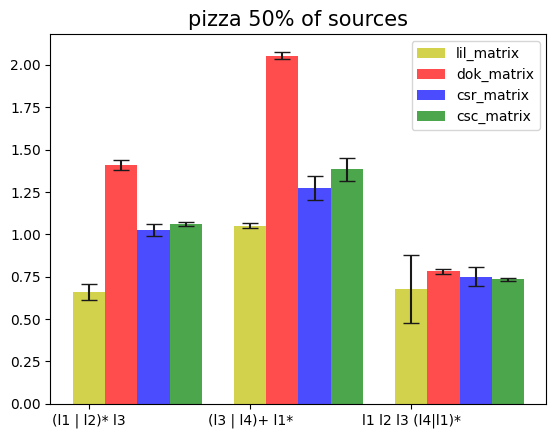

In [17]:
perc_of_src = [10.0, 30.0, 50.0]
for perc in perc_of_src:
    rpq_specified_vertexes_for_each_start(perc_of_src=perc,type_rpq=rpq_by_bfs)

Исходя из полученных данных можно сделать вывод, что решать задачу `достижимости вершин для каждой из заданного множества стартовых вершин` так же выгоднее алгоритмом, основанным на тензорном произведении.

## Дальнейшие эксперименты ставятся на алгоритме, основанном на синхронном обходе автоматов в ширину (BFS)

#### Какое представление разреженных матриц и векторов лучше подходит для каждой из решаемых задач?

Чтобы ответить на данный вопрос, запустим выше представленные функции.

**Достижимость между всеми парами вершин:**

[2022-10-19 23:38:08]>INFO>Found graph with name='pizza'
[2022-10-19 23:38:08]>INFO>Load archive graph_archive=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza.tar.gz')
[2022-10-19 23:38:08]>INFO>Unzip graph name='pizza' to file graph=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza/pizza.csv')
[2022-10-19 23:38:08]>INFO>Remove archive graph_archive=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza.tar.gz')
[2022-10-19 23:38:08]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x0000020EFCBC2700> from path=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza/pizza.csv')


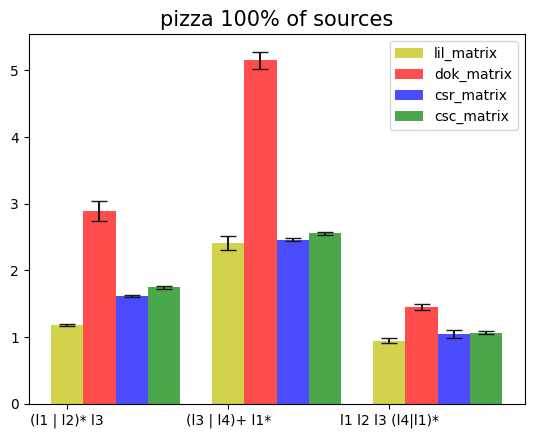

In [10]:
rpq_all_pairs()

**Достижимость вершин с заданным множеством стартовых вершин:**

[2022-10-19 23:38:57]>INFO>Found graph with name='pizza'
[2022-10-19 23:38:57]>INFO>Load archive graph_archive=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza.tar.gz')
[2022-10-19 23:38:57]>INFO>Unzip graph name='pizza' to file graph=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza/pizza.csv')
[2022-10-19 23:38:57]>INFO>Remove archive graph_archive=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza.tar.gz')
[2022-10-19 23:38:57]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x0000020EFCB8A580> from path=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza/pizza.csv')
[2022-10-19 23:38:57]>INFO>Generate set of source vertices of 134 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x0000020EFCB8A580> for multiple-source evaluation


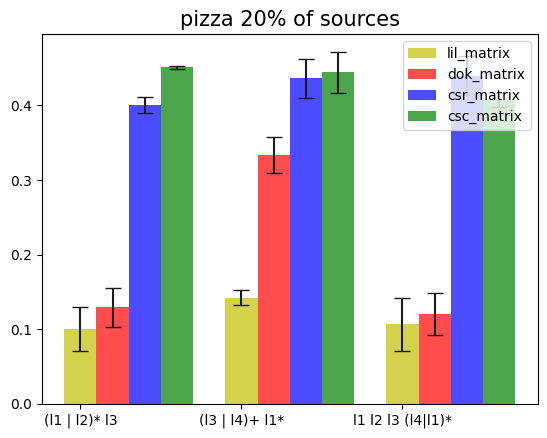

In [11]:
rpq_specified_vertexes(perc_of_src=PERCENT_OF_SOURCES)

**Достижимость вершин для каждой из заданного множества стартовых вершин**

[2022-10-19 23:39:04]>INFO>Found graph with name='pizza'
[2022-10-19 23:39:05]>INFO>Load archive graph_archive=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza.tar.gz')
[2022-10-19 23:39:05]>INFO>Unzip graph name='pizza' to file graph=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza/pizza.csv')
[2022-10-19 23:39:05]>INFO>Remove archive graph_archive=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza.tar.gz')
[2022-10-19 23:39:05]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x0000020ECB0D73A0> from path=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza/pizza.csv')
[2022-10-19 23:39:05]>INFO>Generate set of source vertices of 134 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x0000020ECB0D73A0> for multiple-source evaluation


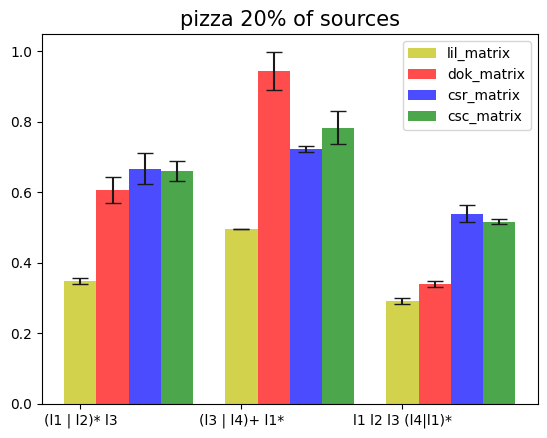

In [12]:
rpq_specified_vertexes_for_each_start(perc_of_src=PERCENT_OF_SOURCES)

Исходя из полученных данных видно, что при решении задач `достижимости между всеми парами вершин` и `для каждой из заданного множества стартовых вершин` [dok_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.dok_matrix.html) на данных графах и регулярных выражениях сильно проигрывает во времени. [lil_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html) показывает наилучший результат, второе место между собой делят [csr_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html) и [csc_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html). Но при решении задачи достижимости `вершин с заданным множеством стартовых вершин` первое место делят [dok_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.dok_matrix.html) и [lil_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html), а [csr_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html) и [csc_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html) явно медленнее.


Можно сделать вывод, что на данных графах и регулярных выражениях наиболее оптимальным вариантом является [lil_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html).

#### Начиная с какого размера стартового множества выгоднее решать задачу для всех пар и выбирать нужные?

Чтобы ответить на данный вопрос, запустим функцию задачи `достижимости для каждой из заданного множества стартовых вершин` с различным количеством стартовых вершин.

[2022-10-19 23:39:19]>INFO>Found graph with name='pizza'
[2022-10-19 23:39:19]>INFO>Load archive graph_archive=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza.tar.gz')
[2022-10-19 23:39:19]>INFO>Unzip graph name='pizza' to file graph=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza/pizza.csv')
[2022-10-19 23:39:19]>INFO>Remove archive graph_archive=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza.tar.gz')
[2022-10-19 23:39:19]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x0000020EFCC8C790> from path=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza/pizza.csv')
[2022-10-19 23:39:19]>INFO>Generate set of source vertices of 67 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x0000020EFCC8C790> for multiple-source evaluation


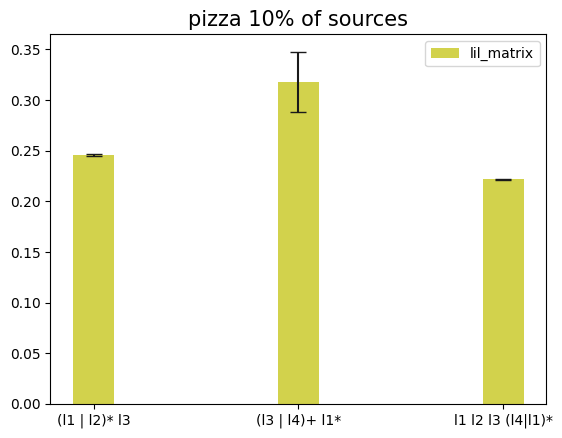

[2022-10-19 23:39:20]>INFO>Found graph with name='pizza'
[2022-10-19 23:39:21]>INFO>Load archive graph_archive=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza.tar.gz')
[2022-10-19 23:39:21]>INFO>Unzip graph name='pizza' to file graph=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza/pizza.csv')
[2022-10-19 23:39:21]>INFO>Remove archive graph_archive=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza.tar.gz')
[2022-10-19 23:39:21]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x0000020EFCCA8670> from path=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza/pizza.csv')
[2022-10-19 23:39:21]>INFO>Generate set of source vertices of 201 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x0000020EFCCA8670> for multiple-source evaluation


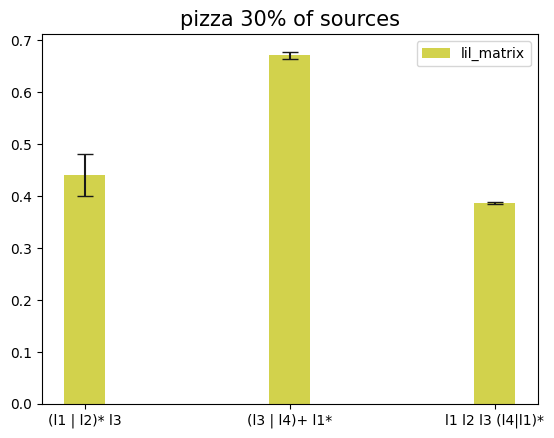

[2022-10-19 23:39:24]>INFO>Found graph with name='pizza'
[2022-10-19 23:39:24]>INFO>Load archive graph_archive=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza.tar.gz')
[2022-10-19 23:39:24]>INFO>Unzip graph name='pizza' to file graph=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza/pizza.csv')
[2022-10-19 23:39:24]>INFO>Remove archive graph_archive=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza.tar.gz')
[2022-10-19 23:39:24]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x0000020EFCE82A30> from path=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza/pizza.csv')
[2022-10-19 23:39:24]>INFO>Generate set of source vertices of 335 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x0000020EFCE82A30> for multiple-source evaluation


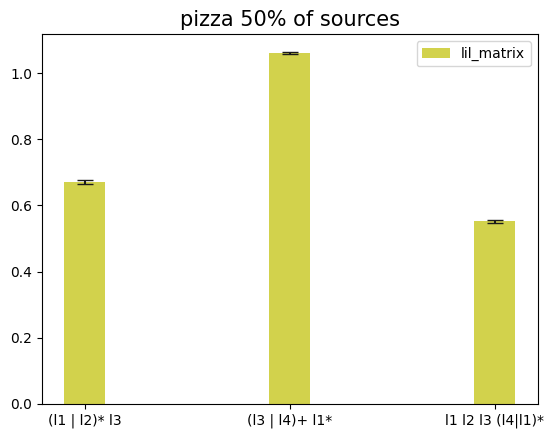

In [13]:
perc_of_src = [10.0, 30.0, 50.0]
for perc in perc_of_src:
    rpq_specified_vertexes_for_each_start(perc_of_src=perc, type_matrices=[lil_matrix])

Исходя из полученных данных, можно сделать вывод, что чем меньше количество стартовых вершин, тем быстрее отрабатывает алгоритм.

#### На сколько решение второй задачи медленнее решения третьей при одинаковых начальных условиях?

Чтобы ответить на данный вопрос, запустим задачи `достижимости для всего множества заданных вершин` и
`достижимости для каждой из заданного множества стартовых вершин` с различным количеством стратовых вершин.

[2022-10-19 23:39:28]>INFO>Found graph with name='pizza'
[2022-10-19 23:39:29]>INFO>Load archive graph_archive=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza.tar.gz')
[2022-10-19 23:39:29]>INFO>Unzip graph name='pizza' to file graph=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza/pizza.csv')
[2022-10-19 23:39:29]>INFO>Remove archive graph_archive=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza.tar.gz')
[2022-10-19 23:39:29]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x0000020EFCC72940> from path=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza/pizza.csv')
[2022-10-19 23:39:29]>INFO>Generate set of source vertices of 67 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x0000020EFCC72940> for multiple-source evaluation


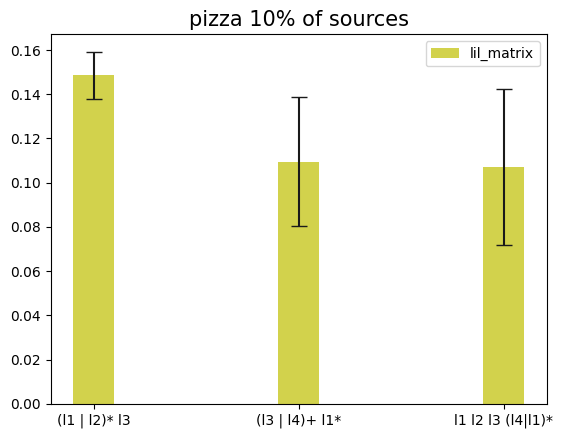

[2022-10-19 23:39:30]>INFO>Found graph with name='pizza'
[2022-10-19 23:39:30]>INFO>Load archive graph_archive=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza.tar.gz')
[2022-10-19 23:39:30]>INFO>Unzip graph name='pizza' to file graph=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza/pizza.csv')
[2022-10-19 23:39:30]>INFO>Remove archive graph_archive=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza.tar.gz')
[2022-10-19 23:39:30]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x0000020EFCF59A90> from path=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza/pizza.csv')
[2022-10-19 23:39:30]>INFO>Generate set of source vertices of 201 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x0000020EFCF59A90> for multiple-source evaluation


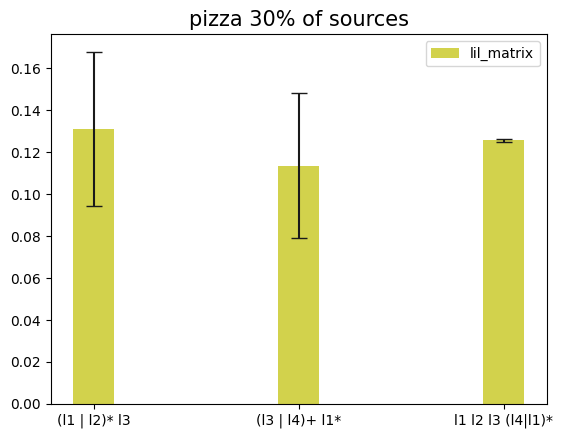

[2022-10-19 23:39:31]>INFO>Found graph with name='pizza'
[2022-10-19 23:39:31]>INFO>Load archive graph_archive=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza.tar.gz')
[2022-10-19 23:39:31]>INFO>Unzip graph name='pizza' to file graph=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza/pizza.csv')
[2022-10-19 23:39:31]>INFO>Remove archive graph_archive=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza.tar.gz')
[2022-10-19 23:39:31]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x0000020EFCC72D90> from path=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza/pizza.csv')
[2022-10-19 23:39:31]>INFO>Generate set of source vertices of 335 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x0000020EFCC72D90> for multiple-source evaluation


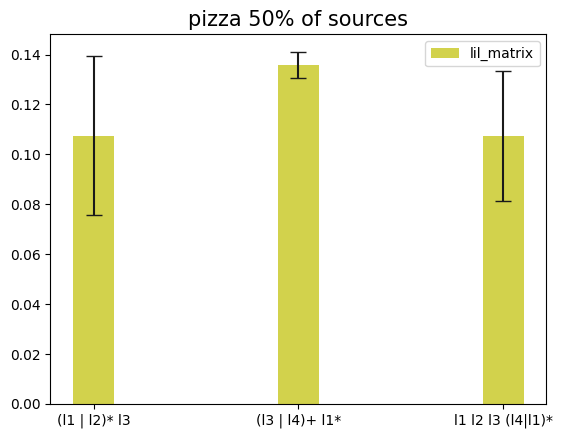

[2022-10-19 23:39:31]>INFO>Found graph with name='pizza'
[2022-10-19 23:39:32]>INFO>Load archive graph_archive=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza.tar.gz')
[2022-10-19 23:39:32]>INFO>Unzip graph name='pizza' to file graph=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza/pizza.csv')
[2022-10-19 23:39:32]>INFO>Remove archive graph_archive=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza.tar.gz')
[2022-10-19 23:39:32]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x0000020EFCF590A0> from path=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza/pizza.csv')
[2022-10-19 23:39:32]>INFO>Generate set of source vertices of 67 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x0000020EFCF590A0> for multiple-source evaluation


-----------------------------------------------------------------------


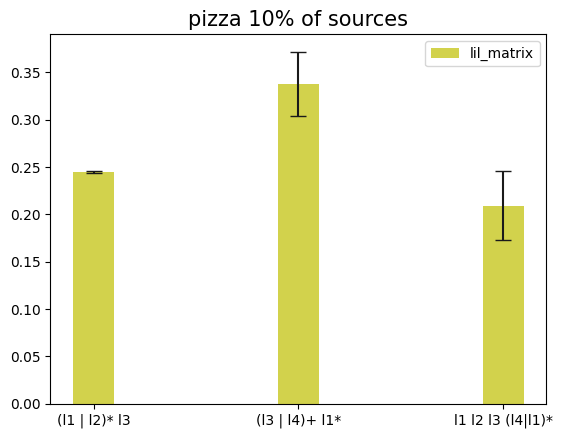

[2022-10-19 23:39:33]>INFO>Found graph with name='pizza'
[2022-10-19 23:39:33]>INFO>Load archive graph_archive=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza.tar.gz')
[2022-10-19 23:39:33]>INFO>Unzip graph name='pizza' to file graph=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza/pizza.csv')
[2022-10-19 23:39:33]>INFO>Remove archive graph_archive=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza.tar.gz')
[2022-10-19 23:39:34]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x0000020EFCE8D610> from path=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza/pizza.csv')
[2022-10-19 23:39:34]>INFO>Generate set of source vertices of 201 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x0000020EFCE8D610> for multiple-source evaluation


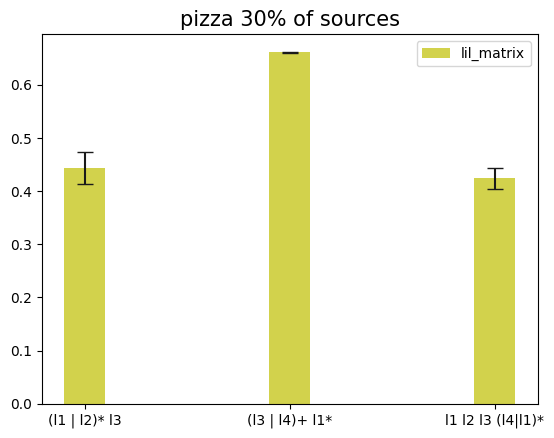

[2022-10-19 23:39:37]>INFO>Found graph with name='pizza'
[2022-10-19 23:39:37]>INFO>Load archive graph_archive=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza.tar.gz')
[2022-10-19 23:39:37]>INFO>Unzip graph name='pizza' to file graph=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza/pizza.csv')
[2022-10-19 23:39:37]>INFO>Remove archive graph_archive=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza.tar.gz')
[2022-10-19 23:39:37]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x0000020ECB0D73A0> from path=WindowsPath('D:/GitHub/formal-lang-course/venv/lib/site-packages/cfpq_data/data/pizza/pizza.csv')
[2022-10-19 23:39:37]>INFO>Generate set of source vertices of 335 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x0000020ECB0D73A0> for multiple-source evaluation


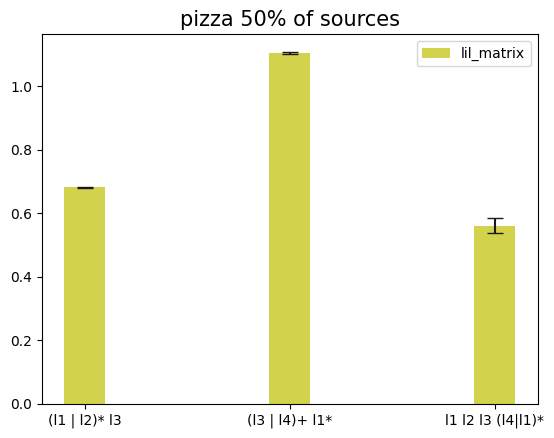

In [14]:
perc_of_src = [10.0, 30.0, 50.0]
for perc in perc_of_src:
    rpq_specified_vertexes(perc_of_src=perc, type_matrices=[lil_matrix])
print("-----------------------------------------------------------------------")
for perc in perc_of_src:
    rpq_specified_vertexes_for_each_start(perc_of_src=perc, type_matrices=[lil_matrix])

Из полученных данных можно увидеть, что на данных графах и регулярных выражениях задача `достижимости для всего множества заданных вершин` работает быстрее, чем задача `достижимости для каждой из заданного множества стартовых вершин`. Данный результат можно объяснить тем, что при нахождении достижимых вершин для *каждой* стартовой вершины, происходит намного больше матричных умножений, а так же матричные операции работают медленнее, так как размер самих матриц больше.